In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import pandas
import pynumdiff

/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/caveman/BMD2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:526: Futu

In [2]:
fname = '/home/caveman/Sync/LAB_Private/RESEARCH/code/PyNumDiff/notebooks/lorenz_x/pareto_sine_freq_data/pareto_data_butterdiff_smooth_finite_difference_sine_0.1_0.1_0.01_4.pickle'

In [3]:
def load_data(fname):
    f = open(fname, 'rb')
    data = pickle.load(f)
    f.close()
    return data

In [4]:
load_data(fname)['metadata']

{'dt': 0.01,
 'freq': 0.1,
 'gammas': [0.00010000000000000009,
  0.0002636650898730362,
  0.0006951927961775613,
  0.0018329807108324375,
  0.00483293023857176,
  0.012742749857031362,
  0.033598182862837875,
  0.08858667904100838,
  0.23357214690901265,
  0.6158482110660278,
  1.6237767391887266,
  4.281332398719401,
  11.288378916846916,
  29.763514416313267,
  78.47599703514625,
  206.91380811147943,
  545.5594781168534,
  1438.449888287665,
  3792.6901907322645,
  10000.00000000001],
 'method': 'butterdiff',
 'method_parent': 'smooth_finite_difference',
 'noise': 0.1,
 'params': [[3, 0.99],
  [3, 0.99],
  [3, 0.99],
  [1, 0.908272552490234],
  [2, 0.3449218749999998],
  [2, 0.16562499999999966],
  [2, 0.07616210937500009],
  [2, 0.04210937500000013],
  [2, 0.02713085937499997],
  [4, 0.023519070625305144],
  [4, 0.018460937499999996],
  [4, 0.014078784942626963],
  [4, 0.011238712310791016],
  [6, 0.005663501739501952],
  [4, 0.003984371185302725],
  [1, 0.00020078262329101552],
  

In [4]:
def get_filenames(path, contains, does_not_contain=['~', '.pyc']):
    cmd = 'ls ' + '"' + path + '"'
    ls = os.popen(cmd).read()
    all_filelist = ls.split('\n')
    try:
        all_filelist.remove('')
    except:
        pass
    filelist = []
    for i, filename in enumerate(all_filelist):
        if contains in filename:
            fileok = True
            for nc in does_not_contain:
                if nc in filename:
                    fileok = False
            if fileok:
                filelist.append( os.path.join(path, filename) )
    return filelist

In [5]:
def get_freq_dt_noise_for_files(dirname, method, method_parent):
    filenames = get_filenames(dirname, method)
    freq = []
    dt = []
    noise = []
    fnames = []
    timeseries_length = []
    
    for fname in filenames:
        data = load_data(fname)
        if method == data['metadata']['method']:
            if method_parent == data['metadata']['method_parent']:
                try:
                    freq.append(data['metadata']['freq'])
                except:
                    freq = None
                dt.append(data['metadata']['dt'])
                noise.append(data['metadata']['noise'])
                fnames.append(fname)
                timeseries_length.append(data['metadata']['timeseries_length'])
                
        
    df = pandas.DataFrame({'freq': freq,
                           'dt': dt,
                           'noise': noise,
                           'fname': fnames,
                           'timeseries_length': timeseries_length})
    return df

In [6]:
def find_elbow(logrmse, errcorr):
    logrmse[np.where(np.isnan(logrmse))] = 100000
    errcorr[np.where(np.isnan(errcorr))] = 100000

    n_logrmse = logrmse-np.min(logrmse)
    n_errcorr = errcorr-np.min(errcorr)

    # find cutoff
    threshold = 0.1
    while len(np.where(n_errcorr<threshold)[0]) < 1:
        threshold += 0.05
    
    n_errcorr_placeholder = np.ones_like(n_errcorr)*100
    n_errcorr_placeholder[np.where(n_errcorr<threshold)] = 0

    n = np.linalg.norm( np.vstack((n_logrmse, n_errcorr_placeholder)), axis=0 )
    idx = np.argmin(n)
    
    return idx, logrmse[idx], errcorr[idx]

In [7]:
def plot_rmse_errcorr(data, ax=None, plot=True):
    if ax is None:
        if plot:
            fig = plt.figure(figsize=(10,5))
            ax = fig.add_subplot(111)
        
    keys = ['rmses', 'errcorrs', 'rmses_gamma', 'errcorrs_gamma']
    for key in keys:
        data[key][np.where(data[key]==None)] = np.nan
        data[key] = data[key].astype(float)
    
    idx, opt_logrmse, opt_errcorr = find_elbow(np.log(data['rmses_gamma']), data['errcorrs_gamma'])
    opt_gamma = data['metadata']['gammas'][idx]
    
    if plot:
        if 0:
            ax.plot(np.log(data['rmses']), data['errcorrs'], '.', color='gray')
            ax.plot(np.log(data['rmses_gamma']), data['errcorrs_gamma'], '-', color='red')
            ax.plot(np.log(data['rmses_gamma']), data['errcorrs_gamma'], '.', color='red')
            ax.plot(opt_logrmse, opt_errcorr, '*', color='red', markersize=20)
        else:
            ax.plot((data['rmses']), data['errcorrs'], '.', color='gray')
            ax.plot((data['rmses_gamma']), data['errcorrs_gamma'], '-', color='red')
            ax.plot((data['rmses_gamma']), data['errcorrs_gamma'], '.', color='red')
            ax.plot(np.exp(opt_logrmse), opt_errcorr, '*', color='red', markersize=20)
            ax.set_xlim(0, 5)
            ax.set_ylim(0, 1)
            
    return opt_gamma

In [8]:
def plot_rmse_errcorr_for_all_freq(dirname, method, method_parent, dt, noise, timeseries_length, plot=True):
    df = get_freq_dt_noise_for_files(dirname, method, method_parent)
    q = "dt == " + str(dt) + " and noise == " + str(noise) + " and timeseries_length == " + str(timeseries_length)
    dfq = df.query(q)
    dfq = dfq.sort_values(by=['freq'])

    n_plots = len(dfq.index)
    fig = plt.figure(figsize=(15,5))
    
    opt_gammas = []
    freqs = []
    
    for n, row in enumerate(dfq.index):
        ax = fig.add_subplot(1,n_plots,n+1)
        fname = dfq.loc[row].fname
        data = load_data(fname)
        opt_gamma = plot_rmse_errcorr(data, ax=ax)
        
        title = 'freq: ' + str(data['metadata']['freq']) + '\n dt: ' + str(data['metadata']['dt']) + '\n noise: ' + str(data['metadata']['noise'])
        ax.set_title(title)

        opt_gammas.append(opt_gamma)
        freqs.append(data['metadata']['freq'])
    
    return opt_gammas, freqs

In [9]:
def get_gamma(dt, freq):
    try:
        g = np.min([100, np.exp(np.log10(freq)*(-3)-1) ])
        
        
        if dt == 0.001:
            return g
        if dt == 0.01:
            return g / 2.5
        if dt == 0.1:
            return g / 5.
        
    except:
        g = [np.min([1000, np.exp(np.log10(f)*(-3)-1) ]) for f in freq]
        
        g = np.array(g)
        
        if dt == 0.001:
            return g
        if dt == 0.01:
            return g / 2.5
        if dt == 0.1:
            return g / 5.


In [11]:
df = get_freq_dt_noise_for_files('pareto_sine_freq_data/', 'savgoldiff', 'linear_model')

In [12]:
df

,dt,fname,freq,noise,timeseries_length
0,0.001,pareto_sine_freq_data/pareto_data_savgoldiff_l...,0.0001,0.001,16
1,0.001,pareto_sine_freq_data/pareto_data_savgoldiff_l...,0.0001,0.001,4
2,0.010,pareto_sine_freq_data/pareto_data_savgoldiff_l...,0.0001,0.001,16
3,0.010,pareto_sine_freq_data/pareto_data_savgoldiff_l...,0.0001,0.001,4
4,0.001,pareto_sine_freq_data/pareto_data_savgoldiff_l...,0.0001,0.010,16
5,0.001,pareto_sine_freq_data/pareto_data_savgoldiff_l...,0.0001,0.010,4
6,0.010,pareto_sine_freq_data/pareto_data_savgoldiff_l...,0.0001,0.010,16
7,0.010,pareto_sine_freq_data/pareto_data_savgoldiff_l...,0.0001,0.010,4
8,0.001,pareto_sine_freq_data/pareto_data_savgoldiff_l...,0.0001,0.100,16
9,0.001,pareto_sine_freq_data/pareto_data_savgoldiff_l...,0.0001,0.100,4


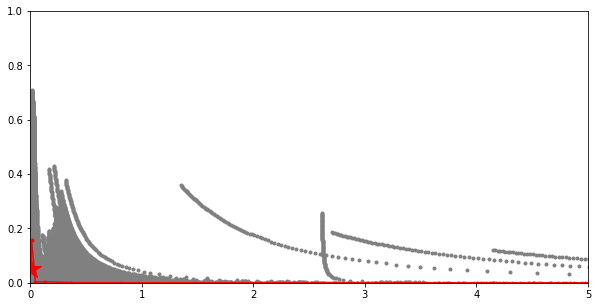

In [14]:
i = 21
data = load_data(df.fname[i])
g = plot_rmse_errcorr(data)

In [17]:
def get_sine_data(noise, dt, timeseries_length, frequencies):
    r = pynumdiff.utils.simulate.sine(timeseries_length, noise_parameters=[0, noise], dt=dt, 
                                      frequencies=frequencies)
    x, x_truth, dxdt_truth, _ = r
    t = np.linspace(0, timeseries_length, len(x))
    #dt = np.mean(np.diff(t))
    return x, x_truth, dxdt_truth, t, dt

In [20]:
get_gamma(0.01, 1)

0.01831563888873418

In [355]:
dt = 0.01
noise = 0.1
timeseries_length = 4
freq = 10
problem = 'sine'

method_parent = 'smooth_finite_difference'
method = 'butterdiff'

In [356]:
x, x_truth, dxdt_truth, t, dt = get_sine_data(noise, dt, timeseries_length, [freq])

# optimizer

In [236]:
dt = 0.01
noise = 0.1
timeseries_length = 4
frequencies = 1
problem = 'sine'

x, x_truth, dxdt_truth, t, dt = get_sine_data(noise, dt, timeseries_length, [frequencies])

In [237]:
method_parent = 'linear_model'
method = 'savgoldiff'
tvgamma = get_gamma(dt, frequencies)
params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](x, dt, tvgamma=tvgamma, padding=5)
x_smooth, xdot_smooth_savgoldiff = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
print(params)

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

[3, 32, 20]


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


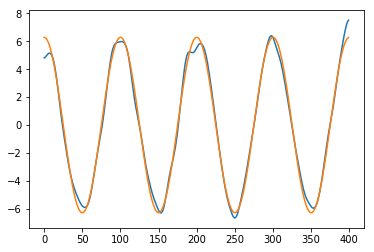

In [238]:
plt.plot(xdot_smooth_savgoldiff)
plt.plot(dxdt_truth)

In [239]:
print(params)

[3, 32, 20]


In [240]:
x_hat, dxdt_hat = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
rms_rec_x, rms_x, rms_dxdt = pynumdiff.utils.evaluate.metrics(x, dt, x_hat, dxdt_hat, 
                                              x_truth=None, dxdt_truth=None, padding=padding)

L = rms_rec_x + tvgamma*pynumdiff.utils.utility.total_variation(dxdt_hat[padding:-padding])
print(L)

0.1928754049295417


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [241]:
rms_rec_x, rms_x, rms_dxdt = pynumdiff.utils.evaluate.metrics(x, dt, x_hat, dxdt_hat, 
                                              x_truth=x_truth, dxdt_truth=dxdt_truth, padding=padding)
print(rms_x, rms_dxdt)

0.03326634631175604 0.33471089086062167


# actual best

In [242]:
fname = df.query('freq == ' + str(frequencies) + ' and noise == ' + str(noise) + ' and dt == ' + str(dt) + ' and timeseries_length == ' + str(timeseries_length)).fname.values[0]

In [243]:
data = load_data(fname)

In [244]:
len(data['rmses'])

99100

In [245]:
idx, _, _ = find_elbow(np.log(data['rmses']), data['errcorrs'])

In [246]:
print(idx, data['rmses'][idx])

50801 0.20137078379653559


In [11]:
def get_params_for_method(method, method_parent):
    if method_parent == 'linear_model' and method == 'savgoldiff':
        params_list = []
        for p1 in range(2,12):
            for p2 in range(3, 1000, 10):
                if p1 >= p2:
                    continue
                for p3 in range(1, 1000, 10):
                    params_list.append([p1,p2,p3])
    if method_parent == 'kalman_smooth' and method == 'constant_acceleration':
        params_list = []
        for p1 in np.logspace(-8, 8, 50):
            for p2 in np.logspace(-8, 8, 50):
                params_list.append([p1,p2])
    if method_parent == 'smooth_finite_difference' and method == 'butterdiff':
        params_list = []
        for p1 in range(2,12):
            for p2 in np.logspace(-8, -0.7, 100):
                params_list.append([p1,p2])
    if method_parent == 'total_variation_regularization' and method == 'jerk':
        params_list = []
        for p1 in np.logspace(-8, 8, 400):
                params_list.append([p1])
                
                
    return params_list

In [248]:
params_list = get_params_for_method('savgoldiff', 'linear_model')

In [249]:
params = params_list[idx]

In [250]:
x_hat, dxdt_hat = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
rms_rec_x, rms_x, rms_dxdt = pynumdiff.utils.evaluate.metrics(x, dt, x_hat, dxdt_hat, 
                                              x_truth=None, dxdt_truth=None, padding=padding)

L = rms_rec_x + tvgamma*pynumdiff.utils.utility.total_variation(dxdt_hat[padding:-padding])
print(L)

0.19457237416960083


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [251]:
rms_rec_x, rms_x, rms_dxdt = pynumdiff.utils.evaluate.metrics(x, dt, x_hat, dxdt_hat, 
                                              x_truth=x_truth, dxdt_truth=dxdt_truth, padding=padding)
print(rms_x, rms_dxdt)

0.023114386893323124 0.18476907084661937


In [398]:
params = [4, 0.5]

In [399]:
method

'butterdiff'

In [400]:
x_smooth, xdot_smooth_savgoldiff = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
print(params)

[4, 0.5]


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


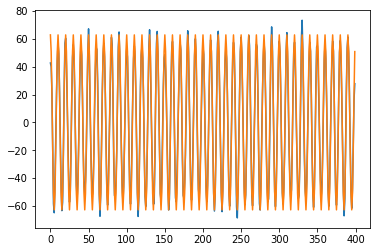

In [401]:
plt.plot(xdot_smooth_savgoldiff)
plt.plot(dxdt_truth)

# figure showing some examples

In [12]:
def show_sine_examples(method, method_parent, problem, rows, cols):
    fig = plt.figure(fig_size=(7,4))
    
    df = get_freq_dt_noise_for_files('pareto_sine_freq_data/', method, method_parent)
    
    dts = df.dt.unique()
    noises = df.noise.unique()
    freqs = df.freq.unique()
    
    N = rows*cols
    

In [15]:
def plot_optimizer_and_actual_best_sine(method, method_parent, dt, noise, freq, timeseries_length=4, 
                                        ax_pos=None, ax_vel=None, plot_truth=True):
    if ax_pos is None or ax_vel is None:
        fig = plt.figure()
        ax_pos = fig.add_subplot(121)
        ax_vel = fig.add_subplot(122)
        
    x, x_truth, dxdt_truth, t, dt = get_sine_data(noise, dt, timeseries_length, [freq])
    
    # optimizer
    tvgamma = get_gamma(dt, freq)
    print('tvgamma: ', tvgamma)
    params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](x, dt, tvgamma=tvgamma)
    x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
    print('optimizer params: ', params)
    
    ax_vel.plot(t, xdot_smooth, color='red')
    if plot_truth:
        ax_vel.plot(t, dxdt_truth, '--', color='black')

    ax_pos.plot(t, x_smooth, color='red')
    if plot_truth:
        ax_pos.plot(t, x, '.', color='blue', zorder=-10)
        ax_pos.plot(t, x_truth, '--', color='black')
    
    # best from all random tries
    if 0:
        try:
            df = get_freq_dt_noise_for_files('pareto_sine_freq_data/', method, method_parent)
            fname = df.query('freq == ' + str(freq) + ' and noise == ' + str(noise) + ' and dt == ' + str(dt) + ' and timeseries_length == ' + str(timeseries_length)).fname.values[0]
            print(fname)
            data = load_data(fname)

            # fix Nones 
            data['rmses'][np.where(data['rmses'] == None)] = 1000
            data['rmses'] = data['rmses'].astype(float)
            data['errcorrs'][np.where(data['errcorrs'] == None)] = 1000
            data['errcorrs'] = data['errcorrs'].astype(float)


            idx, _, _ = find_elbow(np.log(data['rmses']), data['errcorrs'])
            #idx = np.argmin(data['rmses'])
            params_list = get_params_for_method(method, method_parent)
            params = params_list[idx]
            print('best params: ', params)

            x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)

            ax_vel.plot(t, xdot_smooth, color='purple')
            ax_pos.plot(t, x_smooth, color='purple')

        except:
            print('No data for best possible')
            
    L = np.max([2, np.ceil(freq*2*np.pi)])
    ax_vel.set_ylim(-1*L,L)
    
    ax_pos.set_ylim(-1,3)

tvgamma:  1.4778112197861302


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

optimizer params:  [9, 49, 41]


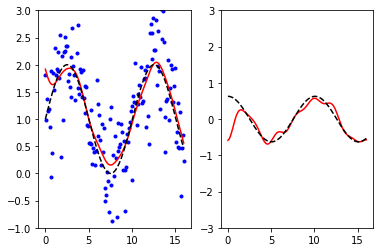

In [652]:
method_parents = ['linear_model']#, 'smooth_finite_difference', 'kalman_smooth', 'total_variation_regularization']
methods = ['savgoldiff']#, 'butterdiff', 'constant_acceleration', 'jerk']


dt = 0.1
noise = 0.5
timeseries_length = 16
freq = .1

for i in range(len(methods)):
    method = methods[i]
    method_parent = method_parents[i]
    plot_optimizer_and_actual_best_sine(method, method_parent, dt, noise, 
                                        freq, timeseries_length=timeseries_length, 
                                        ax_pos=None, ax_vel=None)
        


In [640]:
get_gamma(0.1, 0.1)

1.4778112197861302

In [647]:
np.ceil(.5*2*np.pi)

4.0

tvgamma:  0.1815275356085869


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

optimizer params:  [1, 0.0001]
tvgamma:  0.07357588823428847


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


optimizer params:  [2, 0.9533050537109368]
tvgamma:  2.9556224395722603
optimizer params:  [2, 0.04165332031249993]
tvgamma:  0.01831563888873418
optimizer params:  [2, 0.046718750000000114]
tvgamma:  40.0
optimizer params:  [5, 0.00039999999999999845]
tvgamma:  40.0
optimizer params:  [4, 0.00362149047851562]
tvgamma:  1.4778112197861302
optimizer params:  [2, 0.03937500000000012]
tvgamma:  0.3630550712171738
optimizer params:  [2, 0.02925125122070313]
tvgamma:  0.1815275356085869
optimizer params:  [2, 3, 3]
tvgamma:  0.07357588823428847
optimizer params:  [3, 3, 3]
tvgamma:  2.9556224395722603
optimizer params:  [1, 12, 83]
tvgamma:  0.01831563888873418
optimizer params:  [3, 47, 26]
tvgamma:  40.0
optimizer params:  [1, 690, 450]
tvgamma:  40.0
optimizer params:  [1, 690, 450]
tvgamma:  1.4778112197861302
optimizer params:  [2, 27, 30]
tvgamma:  0.3630550712171738
optimizer params:  [3, 59, 57]
tvgamma:  0.1815275356085869
optimizer params:  [1e-08, 1e-08]
tvgamma:  0.0735758882342

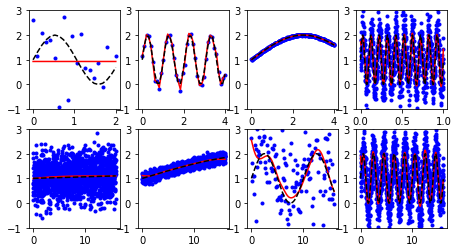

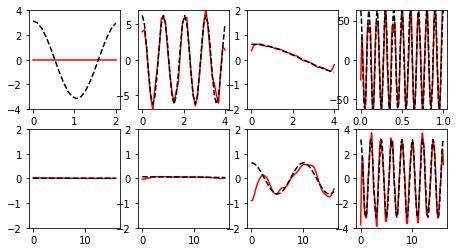

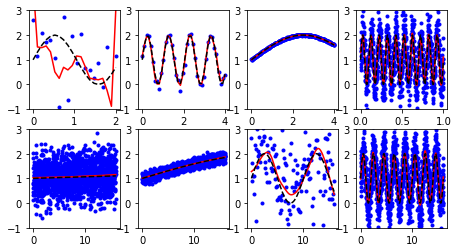

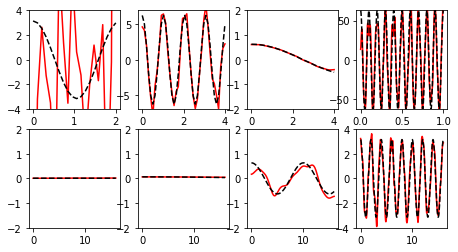

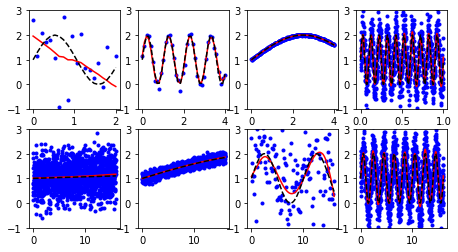

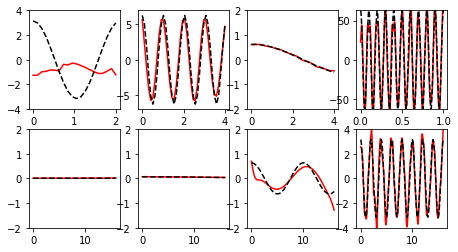

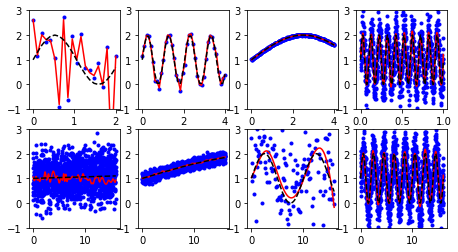

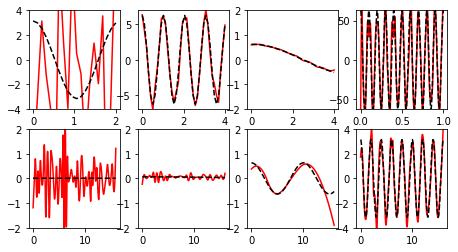

In [18]:
method_parents = ['smooth_finite_difference','linear_model', 'kalman_smooth', 'total_variation_regularization']
methods = ['butterdiff', 'savgoldiff', 'constant_acceleration', 'jerk']


dts = [0.1, 0.1, 0.01, 0.001, 0.01, 0.01, 0.1, 0.01]
noises = [1, 0.1, 0.01, 0.5, 0.5, 0.1, 1, 0.5, 0.5]
timeseries_lengths = [2, 4, 4, 1, 16, 16, 16, 16]
freqs = [0.5, 1, 0.1, 10, 0.001, 0.01, 0.1, 0.5]




for i in range(len(methods)):
    fig_pos = plt.figure(figsize=(7.5, 4))
    fig_vel = plt.figure(figsize=(7.5, 4))

    method = methods[i]
    method_parent = method_parents[i]
        
    for n in range(len(dts)):
        ax_pos = fig_pos.add_subplot(2,4,n+1)
        ax_vel = fig_vel.add_subplot(2,4,n+1)

        plot_optimizer_and_actual_best_sine(method, method_parent, dts[n], noises[n], 
                                                freqs[n], timeseries_length=timeseries_lengths[n], 
                                                ax_pos=ax_pos, ax_vel=ax_vel)
        
    fig_vel.savefig('velocity_' + method + '.pdf')
    fig_pos.savefig('position_' + method + '.pdf')

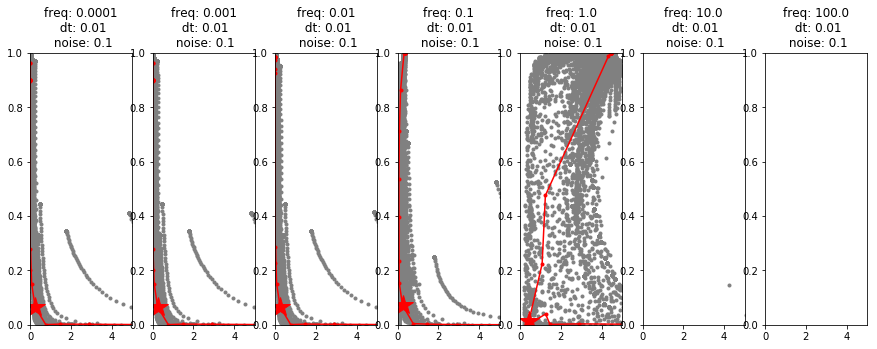

In [15]:
dt = 0.01
noise = 0.1
timeseries_length = 4

g, f = plot_rmse_errcorr_for_all_freq('pareto_sine_freq_data/', 
                                              'savgoldiff', 'linear_model', 
                                              dt, noise, timeseries_length)

In [16]:
g

[0.08858667904100838,
 0.08858667904100838,
 0.08858667904100838,
 0.08858667904100838,
 0.23357214690901265,
 0.012742749857031362,
 0.00010000000000000009]

Text(0,0.5,'Optimal gamma')

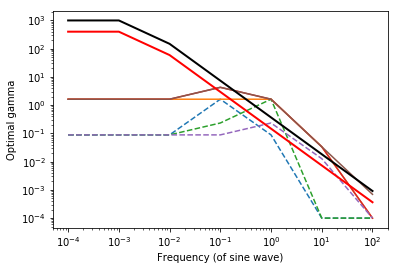

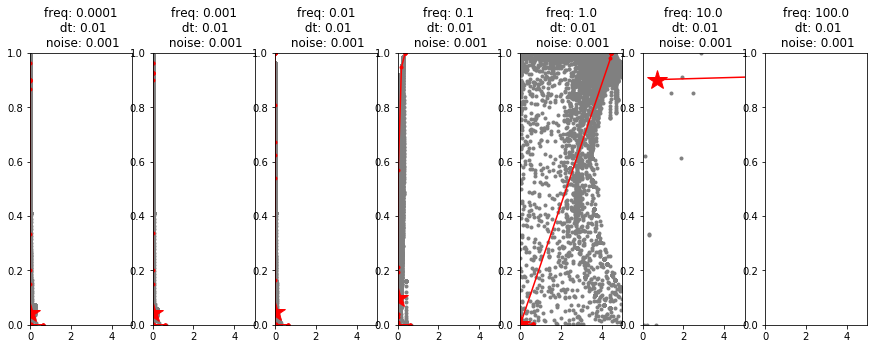

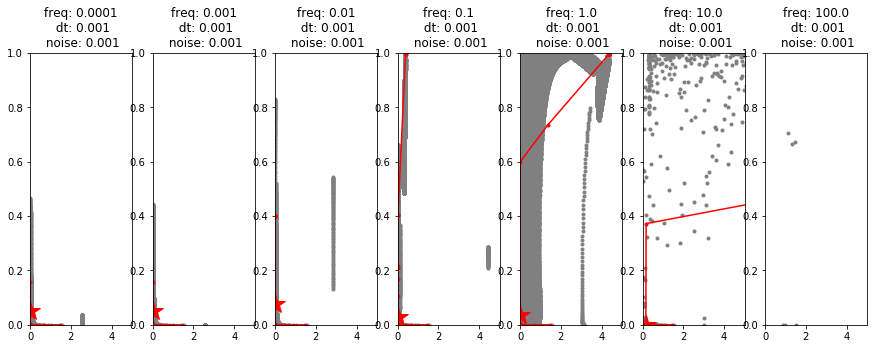

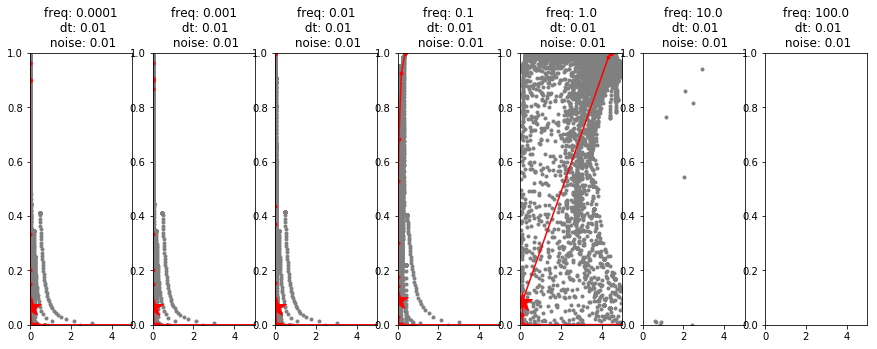

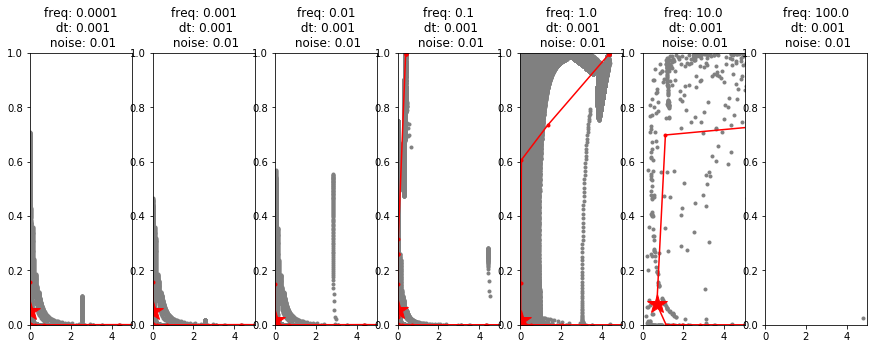

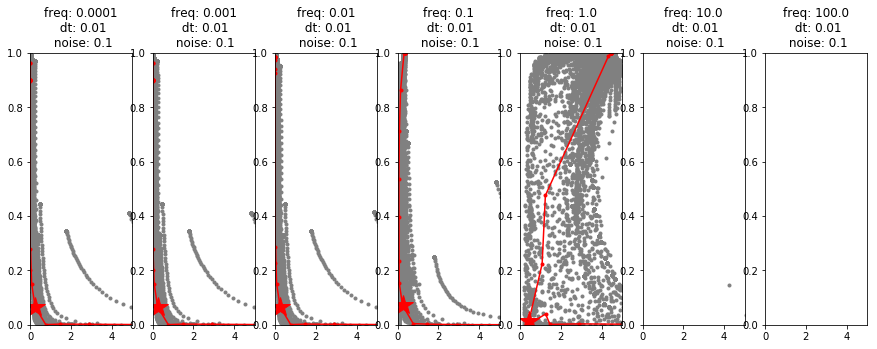

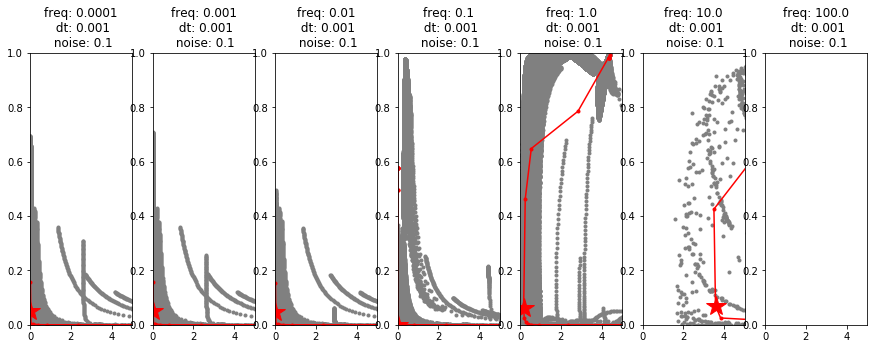

In [644]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xscale("log")
ax.set_yscale("log")

timeseries_length = 4

for noise in [0.001, 0.01, 0.1]:
    for dt in [0.01, 0.001]:
        
        g, f = plot_rmse_errcorr_for_all_freq('pareto_sine_freq_data/', 
                                              'savgoldiff', 'linear_model', 
                                              dt, noise, timeseries_length)
        
        if dt==0.01:
            ax.plot(f,g,'--')
        else:
            ax.plot(f,g,'-')
            
f = [1e-4, 1e-3, 1e-2,1e-1, 1e-1, 1e0, 1e1, 1e2]
ax.plot(f, get_gamma(0.001, f),'-', color='black', linewidth=2)

ax.plot(f, get_gamma(0.01, f),'-', color='red', linewidth=2)

ax.set_xlabel('Frequency (of sine wave)')
ax.set_ylabel('Optimal gamma')

Text(0,0.5,'Optimal gamma')

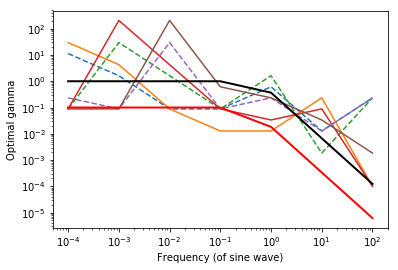

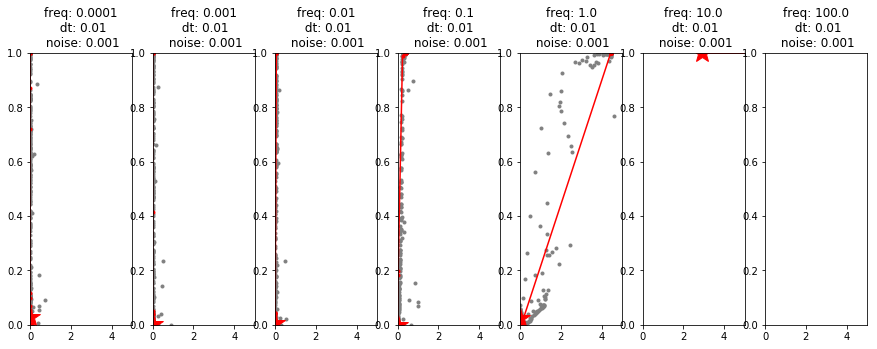

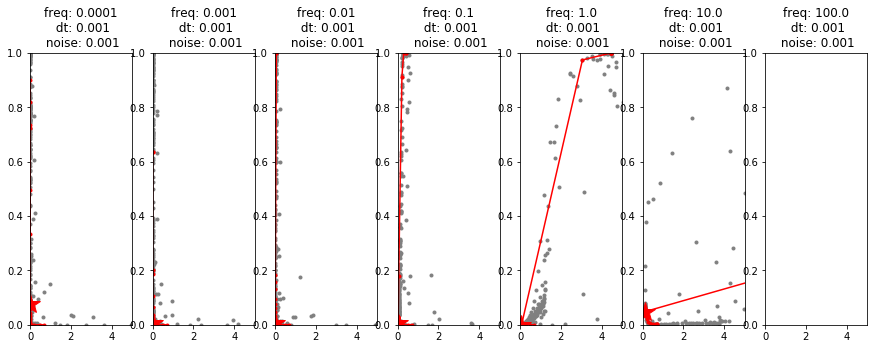

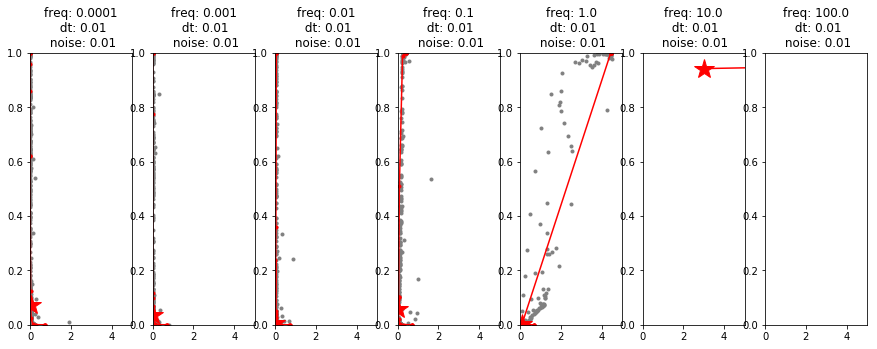

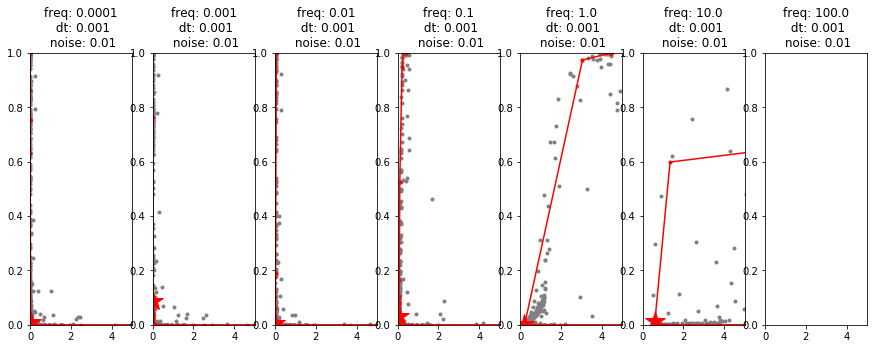

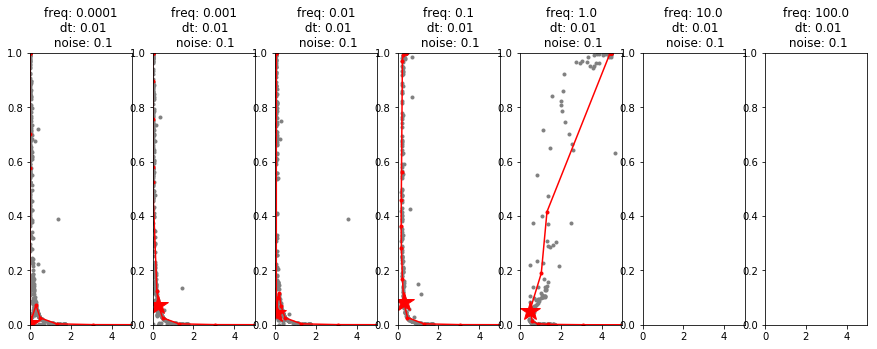

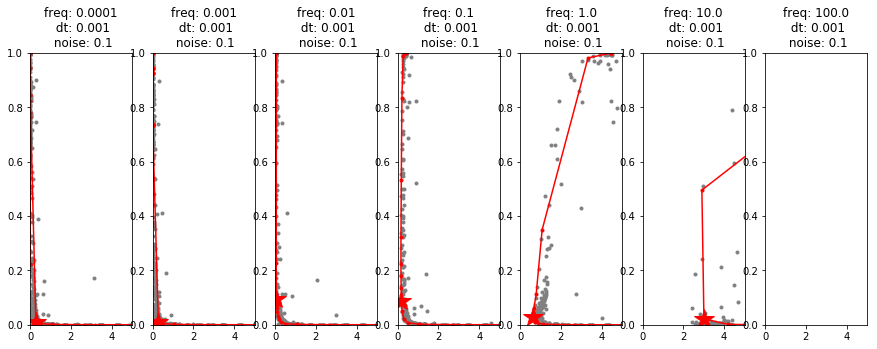

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xscale("log")
ax.set_yscale("log")

timeseries_length = 4

for noise in [0.001, 0.01, 0.1]:
    for dt in [0.01, 0.001]:
        
        g, f = plot_rmse_errcorr_for_all_freq('pareto_sine_freq_data/', 
                                              'butterdiff', 'smooth_finite_difference', 
                                              dt, noise, timeseries_length)
        
        if dt==0.01:
            ax.plot(f,g,'--')
        else:
            ax.plot(f,g,'-')
            
f = [1e-4, 1e-3, 1e-2,1e-1, 1e-1, 1e0, 1e1, 1e2]
ax.plot(f, get_gamma(0.001, f),'-', color='black', linewidth=2)
ax.plot(f, get_gamma(0.01, f),'-', color='red', linewidth=2)

            
ax.set_xlabel('Frequency (of sine wave)')
ax.set_ylabel('Optimal gamma')

Text(0,0.5,'Optimal gamma')

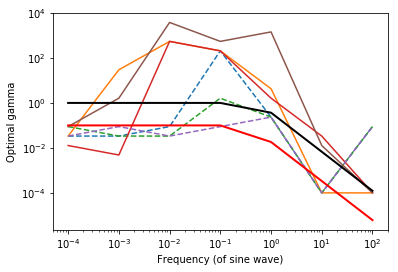

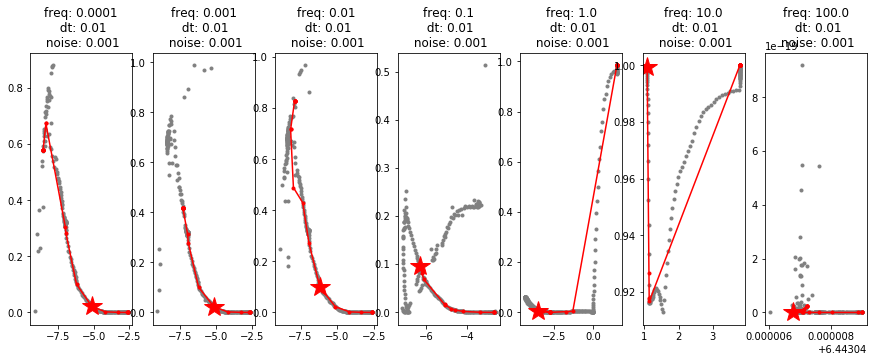

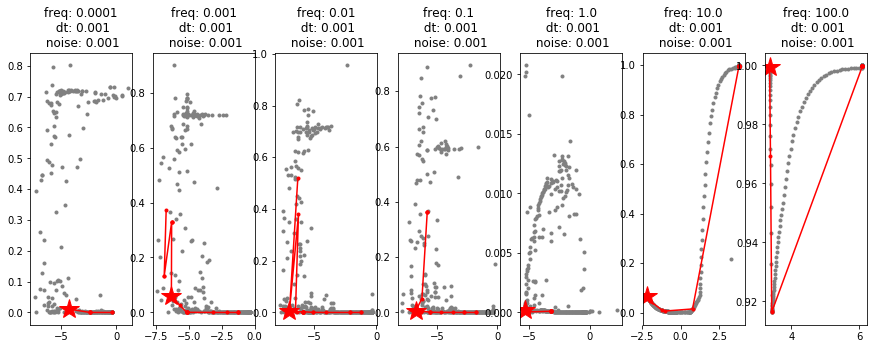

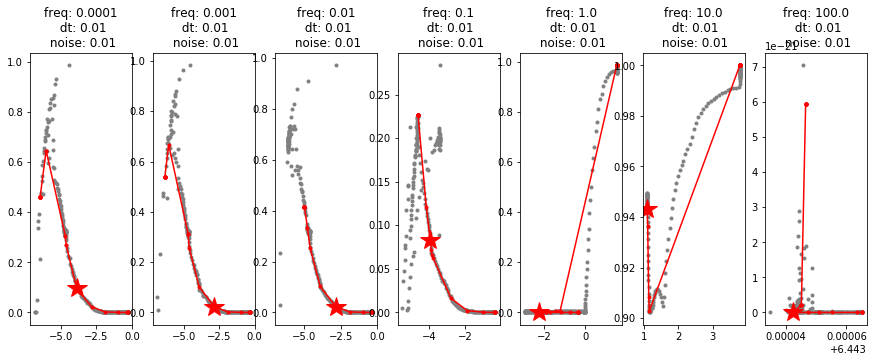

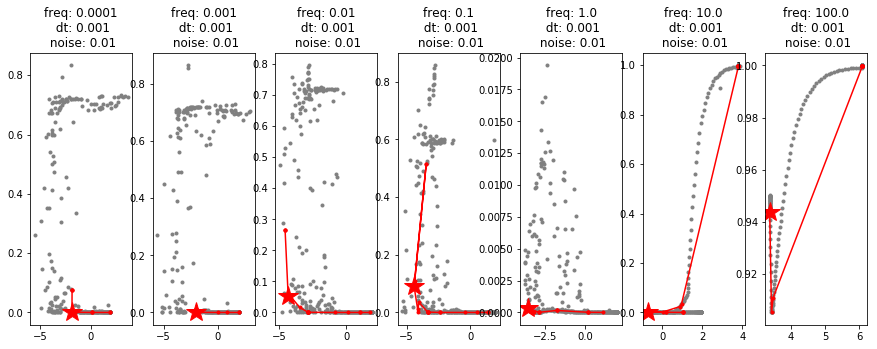

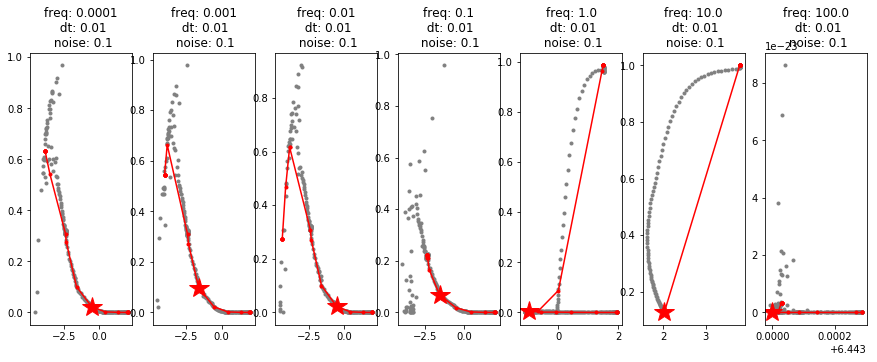

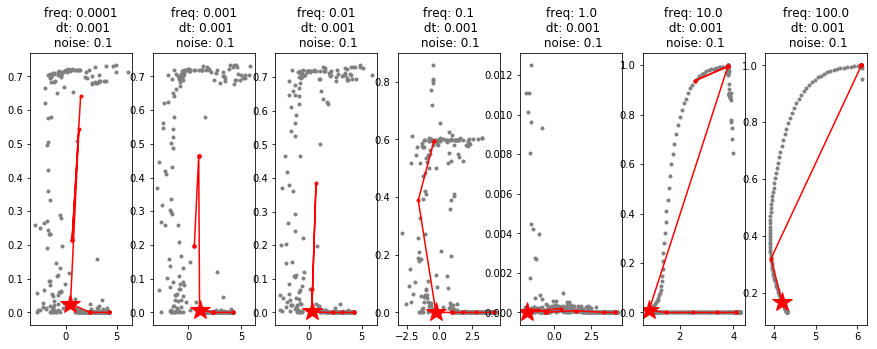

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xscale("log")
ax.set_yscale("log")

timeseries_length = 4

for noise in [0.001, 0.01, 0.1]:
    for dt in [0.01, 0.001]:
        
        g, f = plot_rmse_errcorr_for_all_freq('pareto_sine_freq_data/', 
                                              'jerk', 'total_variation_regularization', 
                                              dt, noise, timeseries_length)
        
        if dt==0.01:
            ax.plot(f,g,'--')
        else:
            ax.plot(f,g,'-')
            
            
f = [1e-4, 1e-3, 1e-2,1e-1, 1e-1, 1e0, 1e1, 1e2]
ax.plot(f, get_gamma(0.001, f),'-', color='black', linewidth=2)
ax.plot(f, get_gamma(0.01, f),'-', color='red', linewidth=2)

ax.set_xlabel('Frequency (of sine wave)')
ax.set_ylabel('Optimal gamma')

In [56]:
np.exp(-np.pi)

0.04321391826377226

Text(0,0.5,'Optimal gamma')

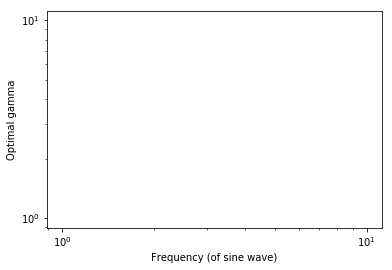

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

<Figure size 1080x360 with 0 Axes>

In [233]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xscale("log")
ax.set_yscale("log")

timeseries_length = 16

for noise in [0.001, 0.01, 0.1]:
    for dt in [0.01, 0.001]:
        
        g, f = plot_rmse_errcorr_for_all_freq('pareto_sine_freq_data/', 
                                              'constant_acceleration', 'kalman_smooth', 
                                              dt, noise, timeseries_length)
        
        if dt==0.01:
            ax.plot(f,g,'--')
        else:
            ax.plot(f,g,'-')
            
ax.set_xlabel('Frequency (of sine wave)')
ax.set_ylabel('Optimal gamma')

In [164]:
def get_rmse_errcorr_for_opt_and_const_gamma(const_gamma, dirname, method, method_parent, dt, noise, timeseries_length):
    df = get_freq_dt_noise_for_files(dirname, method, method_parent)
    q = "dt == " + str(dt) + " and noise == " + str(noise) + " and timeseries_length == " + str(timeseries_length)
    dfq = df.query(q)
    dfq = dfq.sort_values(by=['freq'])

    freqs = []
    opt_rmse = []
    opt_errcorr = []
    const_rmse = []
    const_errcorr = []
    
    for n, row in enumerate(dfq.index):
        fname = dfq.loc[row].fname
        data = load_data(fname)
        
        const_gamma_idx = np.argmin( np.abs( np.array(data['metadata']['gammas'])-const_gamma) )
        opt_gamma = plot_rmse_errcorr(data, ax=ax, plot=False)
        opt_gamma_idx = np.argmin( np.abs( np.array(data['metadata']['gammas'])-opt_gamma) )
        
        opt_rmse.append(data['rmses_gamma'][opt_gamma_idx])
        opt_errcorr.append(data['errcorrs_gamma'][opt_gamma_idx])
        const_rmse.append(data['rmses_gamma'][const_gamma_idx])
        const_errcorr.append(data['errcorrs_gamma'][const_gamma_idx])
        freqs.append(data['metadata']['freq'])
    
    return np.ravel(np.array([opt_rmse])), np.ravel(np.array([opt_errcorr])), np.ravel(np.array([const_rmse])), np.ravel(np.array([const_errcorr])), np.ravel(np.array(freqs))

In [183]:
# how much better would estimate be if we used optimal gamma, as opposed to the one closest to 0.01?
# as function of frequency
def how_much_better(const_gamma, dirname, method, method_parent, dt, noise, timeseries_length):
    opt_rmse, opt_errcorr, const_rmse, const_errcorr, freqs = get_rmse_errcorr_for_opt_and_const_gamma(const_gamma, dirname, 
                                                                                                method, method_parent, dt, 
                                                                                                noise, timeseries_length)
    fig = plt.figure(figsize=(10,5))
    
    ax1 = fig.add_subplot(121)
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    lopt, = ax1.plot(freqs, opt_rmse, color='red', label='opt_gamma')
    lconst, = ax1.plot(freqs, const_rmse, '--', color='black', label='gamma='+str(const_gamma))
    ax1.set_xlabel('freq')
    ax1.set_ylabel('RMSE')
    ax1.legend()
    
    ax2 = fig.add_subplot(122)
    ax2.set_xscale("log")
    ax2.set_yscale("log")
    lopt, = ax2.plot(freqs, opt_errcorr, color='red', label='opt_gamma')
    lconst, = ax2.plot(freqs, const_errcorr, '--', color='black', label='gamma='+str(const_gamma))
    ax2.set_xlabel('freq')
    ax2.set_ylabel('Error Correlation')
    ax2.legend()

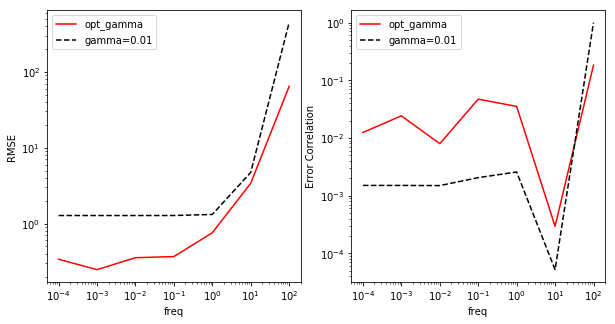

In [209]:
timeseries_length = 4
noise = 0.1
dt = 0.001

dirname = 'pareto_sine_freq_data/'
method = 'butterdiff'
method_parent = 'smooth_finite_difference'

const_gamma = 0.01

how_much_better(const_gamma, dirname, method, method_parent, dt, noise, timeseries_length)

Text(0,0.5,'Optimal gamma')

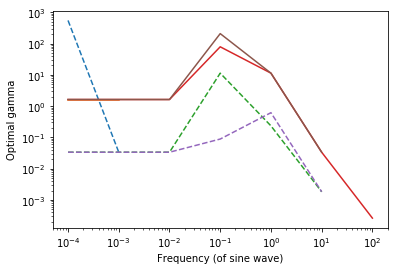

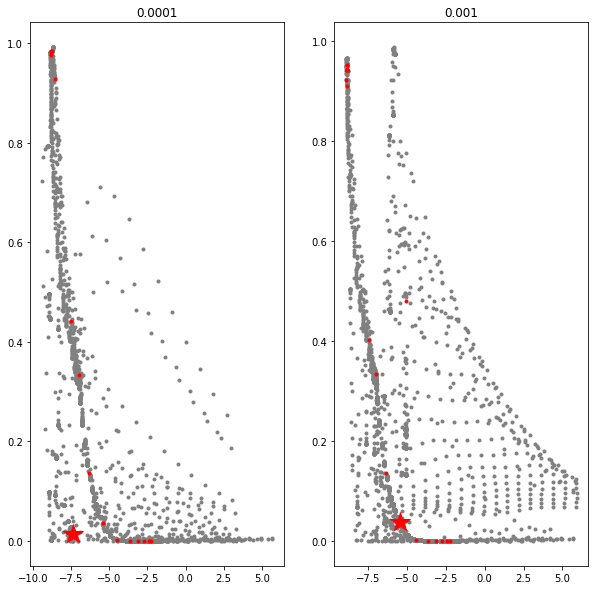

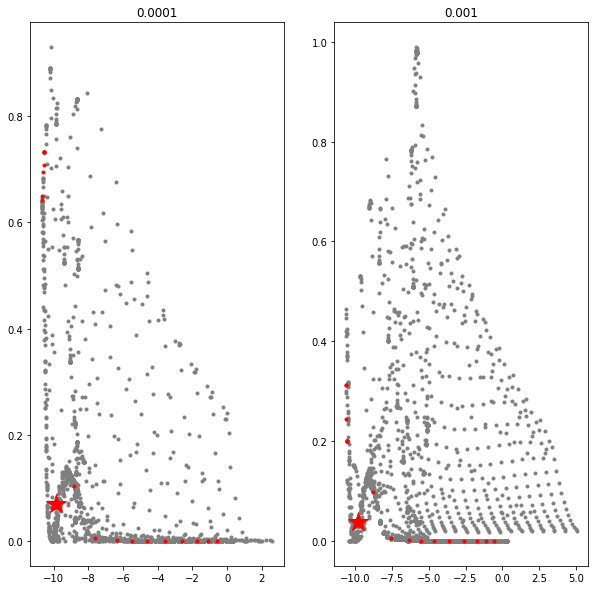

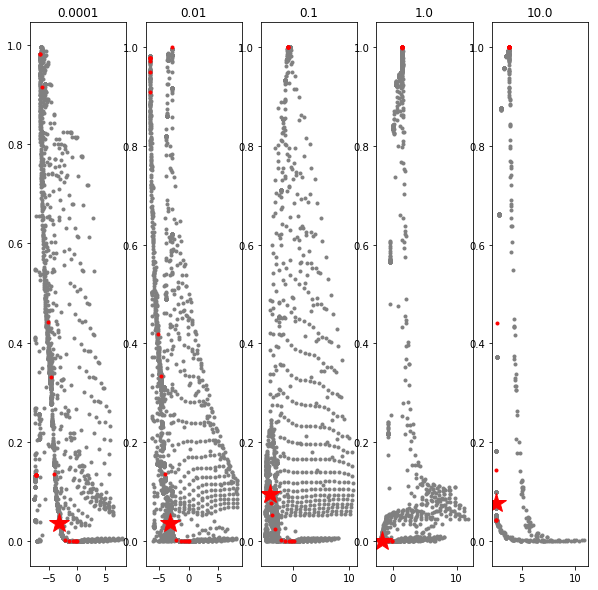

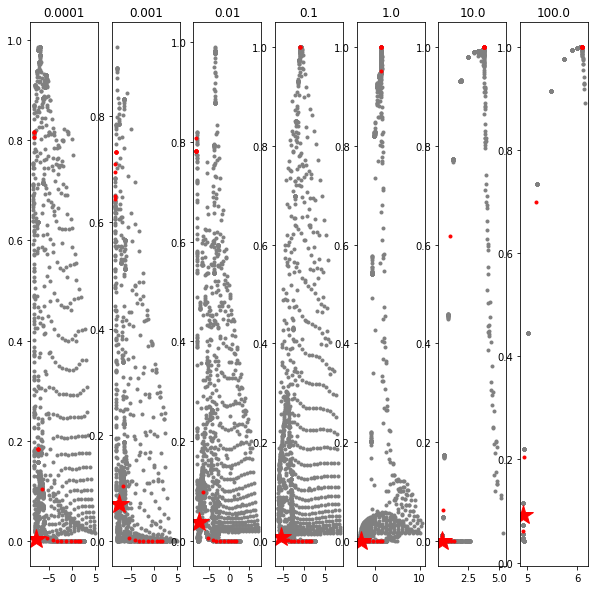

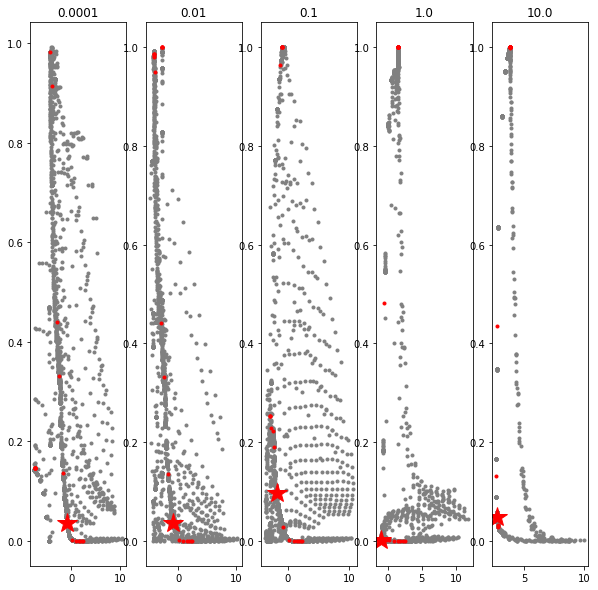

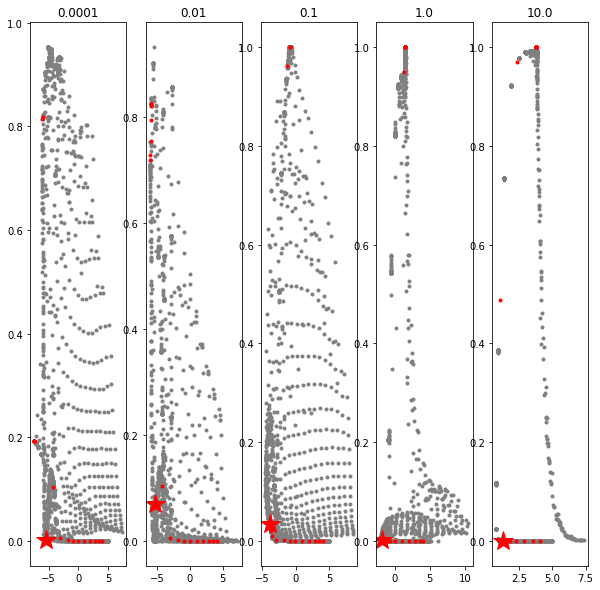

In [75]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xscale("log")
ax.set_yscale("log")

for noise in [0.001, 0.01, 0.1]:
    for dt in [0.01, 0.001]:
        
        g, f = plot_rmse_errcorr_for_all_freq('pareto_sine_freq_data/', 'constant_acceleration', 'kalman_smooth', dt, noise)
        
        if dt==0.01:
            ax.plot(f,g,'--')
        else:
            ax.plot(f,g,'-')
            
ax.set_xlabel('Frequency (of sine wave)')
ax.set_ylabel('Optimal gamma')

# below frequency of 1e-1, the data is basically a flat line!

In [100]:
problem = 'sine'
method = 'butterdiff'
method_parent = 'smooth_finite_difference'

In [101]:
def get_data_sine(problem, freq, noise, dt, timeseries_length):
    r = pynumdiff.utils.simulate.__dict__[problem](timeseries_length, noise_parameters=[0, noise], dt=dt, frequencies=[freq])
    x, x_truth, dxdt_truth, _ = r
    t = np.linspace(0, timeseries_length, len(x))
    #dt = np.mean(np.diff(t))
    return x, x_truth, dxdt_truth, t, dt

Text(0,0.5,'x')

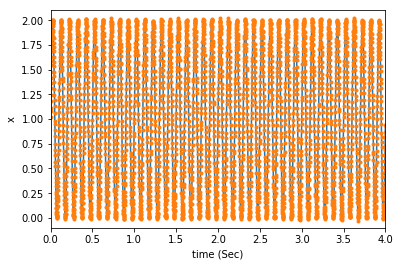

In [118]:
dt = 0.001
noise = 0.01
timeseries_length = 4
freq = 1e1

x, x_truth, dxdt_truth, t, dt = get_data_sine(problem, freq, noise, dt, timeseries_length)

plt.plot(t, x)
plt.plot(t, x, '.')
plt.xlim(0, 4)
plt.ylim(-0.1,2.1)
plt.xlabel('time (Sec)')
plt.ylabel('x')

In [241]:
def get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params):
    
    #params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](wind_speed, dt, tvgamma=gamma_general)
    x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x+np.random.normal(0,0.0,x.shape), dt, params)
    
    rmse = np.sqrt(np.mean((xdot_smooth - dxdt_truth)**2))
    errcorr = pynumdiff.utils.evaluate.error_correlation(xdot_smooth, dxdt_truth)
    
    return rmse, errcorr



In [268]:
def get_rmse_errcorr_for_params_interp(x, x_truth, dxdt_truth, dt, method_parent, method, params):
    N = 4.
    
    t_interp = np.arange(t[0], t[-1], dt/N)
    #x_interp = np.interp(t_interp, t, x)
    f2 = interp1d(t, x, kind='linear')
    x_interp = f2(t_interp)
    x_interp = x_interp + np.random.normal(0, 0.1*np.std(np.diff(x)), x_interp.shape)
    
    #params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](wind_speed, dt, tvgamma=gamma_general)
    x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x_interp, dt/N, params)
    
    xdot_smooth_original_time_base = np.interp(t, t_interp, xdot_smooth)
    
    rmse = np.sqrt(np.mean((xdot_smooth_original_time_base - dxdt_truth)**2))
    errcorr = pynumdiff.utils.evaluate.error_correlation(xdot_smooth_original_time_base, dxdt_truth)
    
    return rmse, errcorr



In [254]:
def get_r_e(x, x_truth, dxdt_truth, dt, method, method_parent, gamma):
    params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](x, dt, tvgamma=gamma)
    #x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
    r, e = get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params)
    return r, e

In [255]:
from scipy.interpolate import interp1d

In [256]:
def get_r_e_interp(x, x_truth, dxdt_truth, dt, method, method_parent, gamma):
    params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](x, dt, tvgamma=gamma)
    #x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
    r, e = get_rmse_errcorr_for_params_interp(x, x_truth, dxdt_truth, dt, method_parent, method, params)
    return r, e

(0, 0.5)

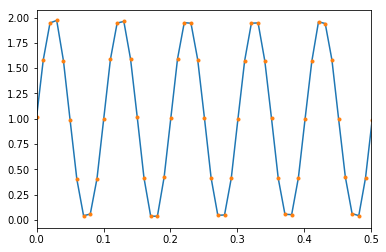

In [257]:
dt = 0.01
noise = 0.01
timeseries_length = 4
freq = 10

x, x_truth, dxdt_truth, t, dt = get_data_sine(problem, freq, noise, dt, timeseries_length)

plt.plot(t, x)
plt.plot(t, x, '.')
plt.xlim(0, 0.5)

In [258]:
method = 'butterdiff'
method_parent = 'smooth_finite_difference'

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

(0, 1)

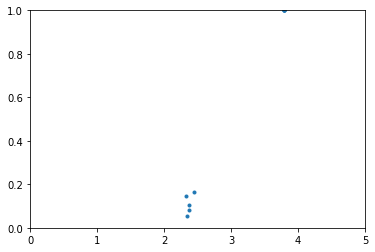

In [269]:
rs = []
es = []

for gamma in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]:
    r, e = get_r_e_interp(x, x_truth, dxdt_truth, dt, method, method_parent, gamma)
    rs.append(r)
    es.append(e)
    
plt.plot(np.log(rs), es, '.')
plt.xlim(0,5)
plt.ylim(0,1)

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

(0, 1)

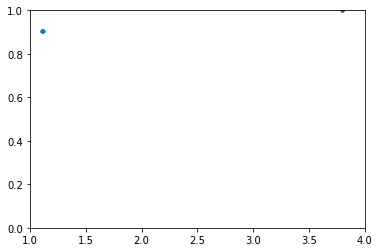

In [251]:
rs = []
es = []

for gamma in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]:
    r, e = get_r_e(x, x_truth, dxdt_truth, dt, method, method_parent, gamma)
    rs.append(r)
    es.append(e)
    
plt.plot(np.log(rs), es, '.')
plt.xlim(1,4)
plt.ylim(0,1)

(0, 1)

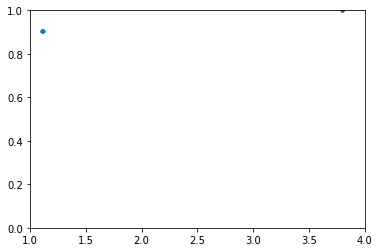

In [250]:
plt.plot(np.log(rs), es, '.')
plt.xlim(1,4)
plt.ylim(0,1)

In [481]:
rs = []
es = []

for gamma in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]:
    r, e = get_r_e_interp(x, x_truth, dxdt_truth, dt, method, method_parent, gamma)
    rs.append(r)
    es.append(e)

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

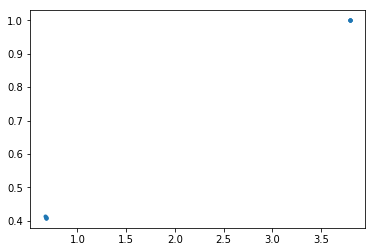

In [483]:
plt.plot(np.log(rs), es, '.')
#plt.xlim(1,4)
#plt.ylim(0,1)

In [414]:
rs

[11.020478070393949,
 11.020478070393949,
 11.020478070393949,
 11.02937202107959,
 11.02812826652495,
 44.39694844656322,
 44.42649806843402,
 44.42649806843402,
 44.42649806843402,
 44.42649806843402,
 44.42649806843402]

In [405]:
params = [6,0.05]

x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x_interp, dt, params)
    
xdot_smooth_original_time_base = np.interp(t, t_interp, xdot_smooth)

r, e = get_rmse_errcorr_for_params(xdot_smooth_original_time_base, x_truth, dxdt_truth, dt, method_parent, method, params)
print(r,e)

44.441722923229605 0.9984783556715335


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [323]:
from multiprocessing import Pool
import multiprocessing

In [324]:
def get_params_for_method(method, method_parent):
    if method_parent == 'linear_model' and method == 'savgoldiff':
        params_list = []
        for p1 in range(2,12):
            for p2 in range(3, 1000, 10):
                if p1 >= p2:
                    continue
                else:
                    params_list.append([p1,p2])
    if method_parent == 'kalman_smooth' and method == 'constant_acceleration':
        params_list = []
        for p1 in np.logspace(-8, 8, 50):
            for p2 in np.logspace(-8, 8, 50):
                params_list.append([p1,p2])
    if method_parent == 'smooth_finite_difference' and method == 'butterdiff':
        params_list = []
        for p1 in range(2,12):
            for p2 in np.logspace(-8, -0.7, 100):
                params_list.append([p1,p2])
    if method_parent == 'total_variation_regularization' and method == 'jerk':
        params_list = []
        for p1 in np.logspace(-8, 8, 400):
                params_list.append([p1])
                
                
    return params_list

In [339]:
def get_pareto_plot_data(x, x_truth, dxdt_truth, dt, method, method_parent, gamma_range, num_gammas=10):
    params_list = get_params_for_method(method, method_parent)
    
    # parallel params computations
    inputs = []
    for p in params_list:
        i = [x, x_truth, dxdt_truth, dt, method_parent, method, p]
        inputs.append(i)


    pool = Pool(20)
    result = pool.map(get_pareto_plot_data_for_params_list, inputs)
    pool.close()
    pool.join()

    rmses = np.vstack(result)[:,0].tolist()
    errcorrs = np.vstack(result)[:,1].tolist()
        
    rmses_gamma = []
    errcorrs_gamma = []
    params_gamma = []
    successful_gammas = []
    
    gammas = np.exp(np.linspace(np.log(gamma_range[0]), np.log(gamma_range[1]), num_gammas)) 
    print(gammas)
    for gamma in gammas:
        try:
            params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](x, dt, tvgamma=gamma)
            #x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
            r, e = get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params)
            rmses_gamma.append(r)
            errcorrs_gamma.append(e)
            successful_gammas.append(gamma)
            params_gamma.append(params)
        except:
            print('FAILED', method, method_parent, gamma)
            
    rmses = np.array(rmses)
    errcorrs = np.array(errcorrs)
    rmses_gamma = np.array(rmses_gamma)
    errcorrs_gamma = np.array(errcorrs_gamma)
    
    return rmses, errcorrs, rmses_gamma, errcorrs_gamma, params_gamma, successful_gammas

In [340]:

def get_pareto_plot_data_for_params_list(inputs):
    x, x_truth, dxdt_truth, dt, method_parent, method, params = inputs
    try:
        r, e = get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params)
    except:
        r = None
        e = None
    return r, e

In [341]:
rmses, errcorrs, rmses_gamma, errcorrs_gamma, params_gamma, successful_gammas = get_pareto_plot_data(x, x_truth, dxdt_truth, dt, method, method_parent, [1e-4,1e4], num_gammas=10)

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

[1.00000000e-04 7.74263683e-04 5.99484250e-03 4.64158883e-02
 3.59381366e-01 2.78255940e+00 2.15443469e+01 1.66810054e+02
 1.29154967e+03 1.00000000e+04]


/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

In [342]:
plt.plot(np.log(rmses), errcorrs)

TypeError: loop of ufunc does not support argument 0 of type float which has no callable log method

In [343]:
errcorrs_gamma

array([0.90697732, 0.90490261, 0.90098826, 0.99969478, 0.99999972,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999])

In [344]:
rmses_gamma

array([ 3.03639385,  3.04088865,  3.04895215, 44.38755567, 44.42897016,
       44.42885386, 44.42885386, 44.42885386, 44.42885386, 44.42885386])

In [345]:
gammas

NameError: name 'gammas' is not defined

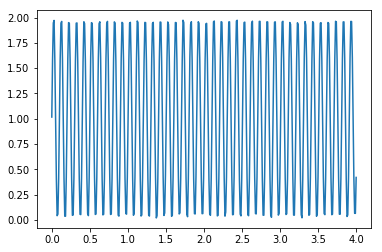

In [349]:
plt.plot(t, x)

In [228]:
rs

[0.03330369233734332,
 0.03330369233734332,
 0.03330369233734332,
 0.03330369233734332,
 0.9998474721895344,
 0.9998474721895344]

In [229]:
es

[0.03330369233734332,
 0.03330369233734332,
 0.03330369233734332,
 0.03330369233734332,
 0.9998474721895344,
 0.9998474721895344]

In [166]:
t_interp = np.arange(t[0], t[-1], dt/2)

(0, 0.5)

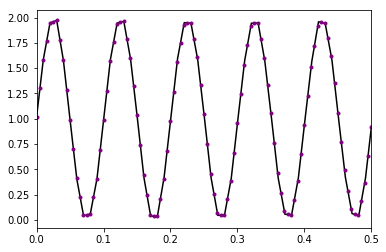

In [174]:
plt.plot(t, x, color='black')
#plt.plot(t, x, '.', color='black')

plt.plot(t_interp, x_interp, '.', color='purple')

plt.xlim(0, 0.5)



In [161]:
gamma = 1e-2

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is depre

In [188]:

#r, e = get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params)

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(0, 0.5)

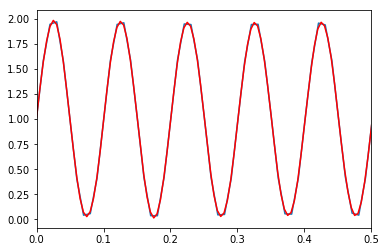

In [178]:
plt.plot(t, x)
#plt.plot(t, x, '.')
plt.plot(t_interp, x_smooth, color='red')
plt.xlim(0, 0.5)

(0, 0.5)

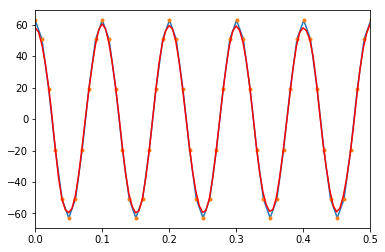

In [179]:
plt.plot(t, dxdt_truth)
plt.plot(t, dxdt_truth, '.')
plt.plot(t_interp, xdot_smooth, color='red')
plt.xlim(0, 0.5)

In [181]:
# phase matters

(0, 0.5)

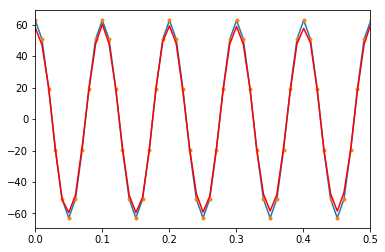

In [183]:
plt.plot(t, dxdt_truth)
plt.plot(t, dxdt_truth, '.')
plt.plot(t, xdot_smooth_original_time_base, color='red')
plt.xlim(0, 0.5)

In [180]:
def get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params):
    
    #params, v = pynumdiff.optimize.__dict__[method_parent].__dict__[method](wind_speed, dt, tvgamma=gamma_general)
    x_smooth, xdot_smooth = pynumdiff.__dict__[method_parent].__dict__[method](x, dt, params)
    
    rmse = np.sqrt(np.mean((xdot_smooth - dxdt_truth)**2))
    errcorr = pynumdiff.utils.evaluate.error_correlation(xdot_smooth, dxdt_truth)
    
    return rmse, errcorr

r, e = get_rmse_errcorr_for_params(x, x_truth, dxdt_truth, dt, method_parent, method, params)

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [185]:
r

2457.879599689027

In [186]:
e

0.0004878595220035515

In [192]:
r, e = get_rmse_errcorr_for_params(xdot_smooth, x_truth, dxdt_truth, dt, method_parent, method, params)

/home/caveman/BMD2/lib/python3.5/site-packages/scipy-1.1.0-py3.5-linux-x86_64.egg/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [193]:
r

2443.2717840485398

In [194]:
e

0.0004515772748733348

In [ ]:
# need function so i can compare whether interpolation helps for different gammas

In [338]:
import pynumdiff

In [341]:
pynumdiff.utils.simulate.sine()